In [3]:
import os
import glob
from PIL import Image
from torch_snippets import *
from sklearn.model_selection import train_test_split
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms

In [2]:
!pip install -qU torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.4 MB/s eta 0:00:00


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Download the dataset**

In [5]:
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip open-images-bus-trucks.zip
!rm open-images-bus-trucks.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/images/a67fe464c9c70f5d.jpg  
  inflating: images/images/a683b991597ef5a1.jpg  
  inflating: images/images/a68858a316999d02.jpg  
  inflating: images/images/a68c64c8fc996e2f.jpg  
  inflating: images/images/a68e2c3746b43efe.jpg  
  inflating: images/images/a6919da5b27eab7c.jpg  
  inflating: images/images/a69229cf87bd0c1a.jpg  
  inflating: images/images/a6936ea349360dda.jpg  
  inflating: images/images/a69782378ab216fa.jpg  
  inflating: images/images/a69f6ee5964a59b1.jpg  
  inflating: images/images/a6a015f4dffec6ab.jpg  
  inflating: images/images/a6a7516de40fbc05.jpg  
  inflating: images/images/a6aa310bd8eea104.jpg  
  inflating: images/images/a6aadcf43f4ca464.jpg  
  inflating: images/images/a6b383c75e535cac.jpg  
  inflating: images/images/a6b4621118e8e034.jpg  
  inflating: images/images/a6c61a6228e7cbbc.jpg  
  inflating: images/images/a6cf70fe15323a12.jpg  
  inflating: images/images/a6d181b95bd96a0e.jpg  

In [6]:
IMAGE_ROOT = 'images/images'
DF_RAW = df = pd.read_csv('df.csv')

In [7]:
# Define the indices corresponding to labels and targets
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [8]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2, 0, 1)
  return img.to(device).float()

**Dataset class**

In [9]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
      self.image_dir = image_dir
      self.files = glob.glob(self.image_dir+'/*')
      self.df = df
      self.image_infos = df.ImageID.unique()

    def __getitem__(self, ix):
      # load images and masks
      image_id = self.image_infos[ix]
      img_path = find(image_id, self.files)
      img = Image.open(img_path).convert("RGB")
      img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
      data = df[df['ImageID'] == image_id]
      labels = data['LabelName'].values.tolist()
      data = data[['XMin','YMin','XMax','YMax']].values
      data[:,[0,2]] *= self.w
      data[:,[1,3]] *= self.h
      boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
      # torch FRCNN expects ground truths as a dictionary of tensors
      target = {}
      target["boxes"] = torch.Tensor(boxes).float()
      target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
      img = preprocess_image(img)
      return img, target

    def collate_fn(self, batch):
      return tuple(zip(*batch))

    def __len__(self):
      return len(self.image_infos)

In [10]:
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [11]:
len(train_ds), len(test_ds)

(13702, 1523)

**Model**

In [12]:
def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [13]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    inputs, targets = inputs
    # Convert inputs to list of tensors on the correct device
    inputs = [img.to(device) for img in inputs]
    # Convert targets to the correct format
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(inputs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()

    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [14]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 109MB/s]


In [15]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)


EPOCH: 1.000  trn_objectness_loss: 0.017  val_loss: 0.173  trn_rpn_box_reg_loss: 0.008  val_regr_loss: 0.080  val_rpn_box_reg_loss: 0.009  trn_regr_loss: 0.083  trn_loss: 0.185  val_objectness_loss: 0.014  val_loc_loss: 0.070  trn_loc_loss: 0.077  (2834.52s - 11338.09s remaining)
EPOCH: 2.000  trn_objectness_loss: 0.010  val_loss: 0.174  trn_rpn_box_reg_loss: 0.007  val_regr_loss: 0.079  val_rpn_box_reg_loss: 0.009  trn_regr_loss: 0.074  trn_loss: 0.156  val_objectness_loss: 0.015  val_loc_loss: 0.071  trn_loc_loss: 0.064  (5663.41s - 8495.11s remaining)
EPOCH: 2.035  trn_loss: 0.158  trn_loc_loss: 0.072  trn_regr_loss: 0.071  trn_objectness_loss: 0.012  trn_rpn_box_reg_loss: 0.003  (5757.92s - 8389.05s remaining)

KeyboardInterrupt: 

100%|██████████| 106/106 [00:00<00:00, 230.50it/s]


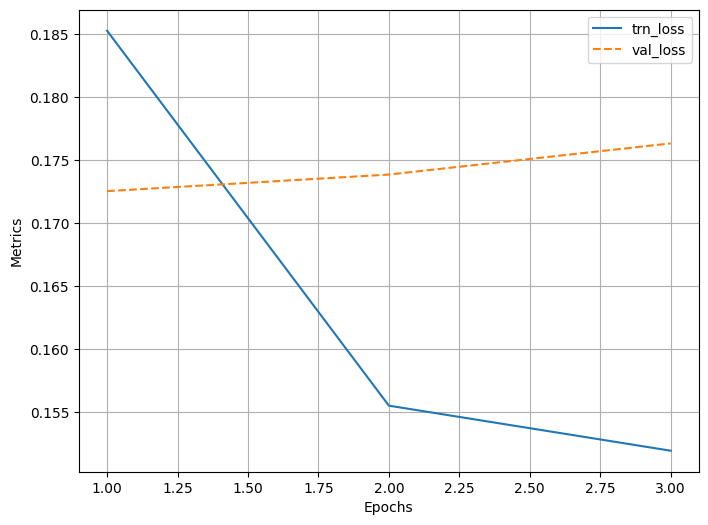

In [16]:
log.plot_epochs(['trn_loss','val_loss'])

In [17]:
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

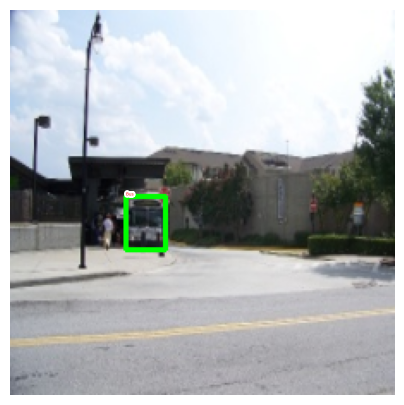

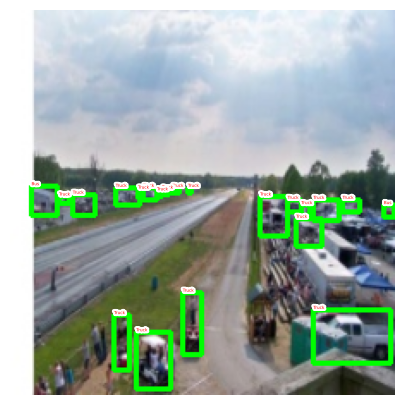

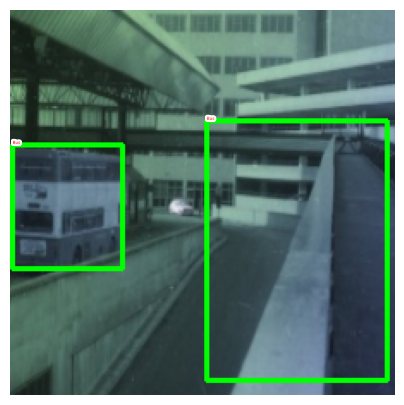

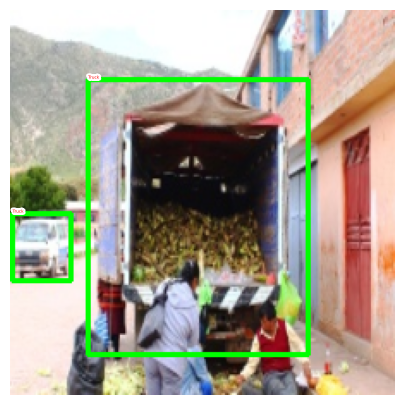

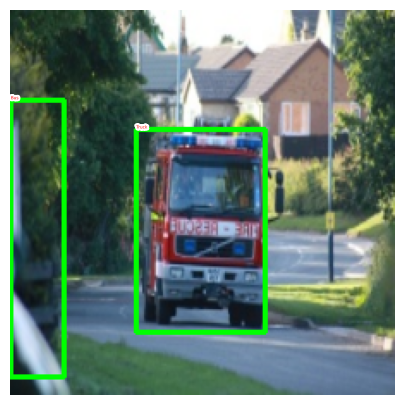

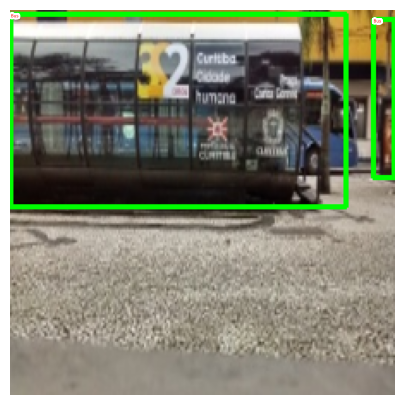

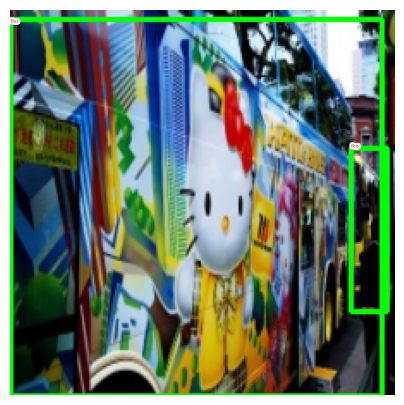

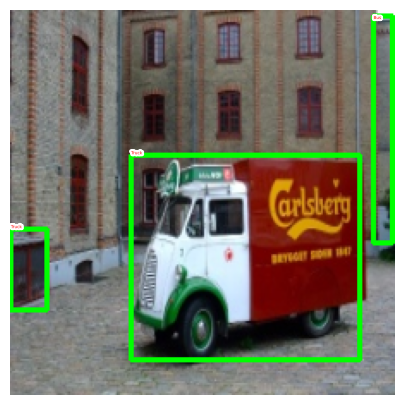

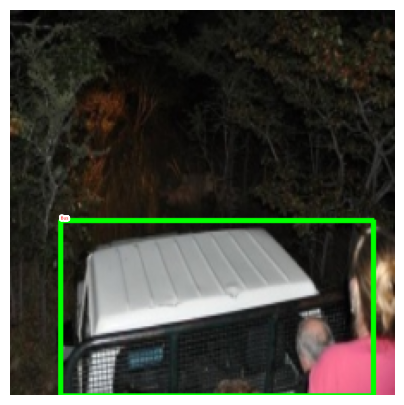

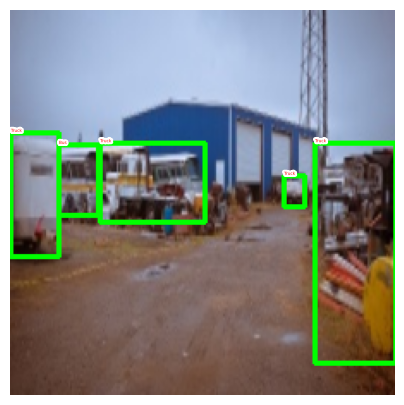

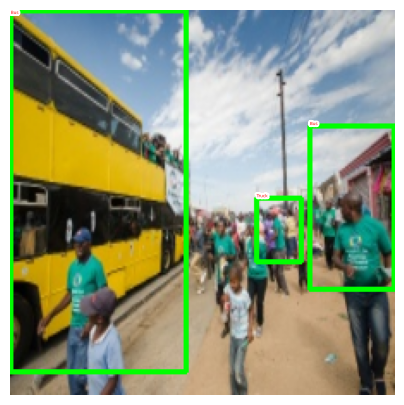

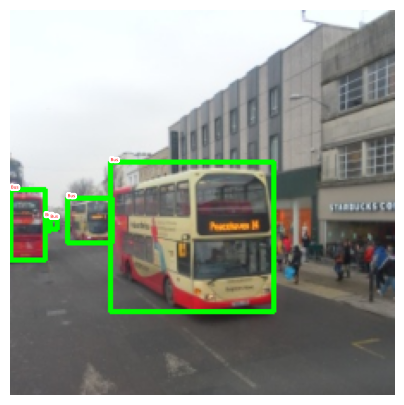

In [18]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)